In [1]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from sklearn.decomposition import PCA
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from pathlib import Path
import dotenv
import json
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'transfer_learn'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

import tools
from task import rules_dict
from network import Model
from tools_lnd import get_model_params, gen_trial_set, gen_trials_from_model_dir, remove_spines
from tools_lnd import make_FP_axs, get_filename, gen_D_fp_qr

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# ##################################################################
# #fig save path
# ##################################################################
fig_name = 'fig6'
figpath = os.path.join(p_code,'figs',fig_name,fig_name+'_DE')
if not os.path.exists(figpath):
    os.makedirs(figpath)

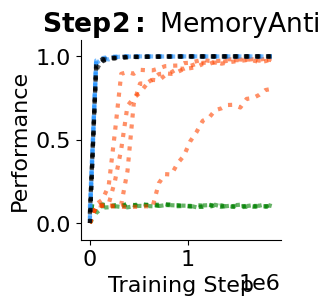

In [21]:
n_steps = 30
rnn_type = 'LeakyRNN'
activation = 'softplus'
w_init = 'diag'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = str(1)
lr = -7
post_train = 'delayanti'

c_set = {'pro_small':'orangered','mem_anti_motifs':'dodgerblue','all':'k','untrained':'g'}
labels = {'pro_small':'DelayPro, MemoryPro',
          'mem_anti_motifs':'DelayAnti, MemoryPro',
          'all':'All tasks except MemoryAnti',
          'untrained':'No pre-training'}

fig = plt.figure(figsize=(2, 2)) #7,2
plt.rcParams.update({'font.size': 16})
ax_post = fig.add_axes([0,0,1,1])

data_to_save = []

for ruleset in ['untrained','pro_small','mem_anti_motifs','all']:#'all',

    task_set = rules_dict[ruleset]
    if ruleset=='all':
        task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                    'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
        task_set.pop(5)
        n_tasks = str(2) #error in saving filenames
    else:
        n_tasks = str(len(task_set))
    rule_trains_str = '_'.join(task_set)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    for seed_ind in range(4):
        
        seed=str(seed_ind)
        if ruleset=='all': #error in saving filenames
            file = '_'.join([rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed])
        else:
            file = '_'.join([rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed])
        m = os.path.join(p_data,fig_name,ruleset,file)

        plt.sca(ax_post)
        with open(os.path.join(m,'log.json'), 'r') as f:
            log_post = json.load(f)
        rule = 'delayanti'
        plt.plot(log_post['trials'][:n_steps],(log_post['perf_'+rule][:n_steps]),':',c = c_set[ruleset],
                 alpha = .6,linewidth = 3,label = 'single task network')

        data_to_save.append({
          'ruleset': ruleset,
          'trials': log_post['trials'][:n_steps],
          'performance': (log_post['perf_'+rule][:n_steps])
        })
        
        ax_post.set_xlabel('Training Step')
        ax_post.set_ylabel('Performance')
        ax_post.set_title(r"$\bf{Step 2 :}$"+' MemoryAnti')
        ax_post.spines['top'].set_visible(False)
        ax_post.spines['right'].set_visible(False)
        plt.ylim([-.1,1.1])

    figname = 'cost_transfer_pre_post'
    plt.savefig(os.path.join(figpath,figname+ruleset+'.pdf'),bbox_inches = 'tight')

In [22]:
import csv

# After the loop, save data to CSV
with open(os.path.join(figpath,'fig6b.csv'), 'w', newline='') as csvfile:
  writer = csv.DictWriter(csvfile, fieldnames=['ruleset', 'trials', 'performance'])
  writer.writeheader()
  writer.writerows(data_to_save)


In [4]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance with the dtype argument instea

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/__autograph_generated_filem8e09iq4.py:45: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(xi) is 0, if_body, else_body, get_state, set_state, ('gate_input_sum',), 1)
2024-04-08 08:27:15.704625: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_3/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_3/model.ckpt


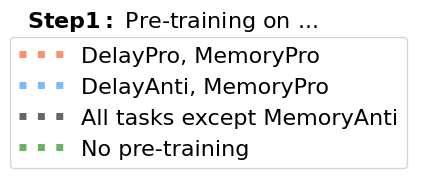

In [7]:
fig = plt.figure(figsize=(.1, .1)) #7,2
plt.rcParams.update({'font.size': 16})
ax = plt.subplot(111)

for ruleset in ['pro_small','mem_anti_motifs','all','untrained']:
    plt.plot(0,0,':',c =c_set[ruleset],alpha = .6,linewidth = 5,label = labels[ruleset])

plt.text(-5.5,.1,r"$\bf{Step 1 :}$"+' Pre-training on ... ')
plt.legend(bbox_to_anchor=(0, .6, 1, 1))
remove_spines(ax)
ax.set_yticks([])
ax.set_xticks([])

figname = 'perf legend'
plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches = 'tight')

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
delay1
go1
go1
go1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradrisc

/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3293: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatib

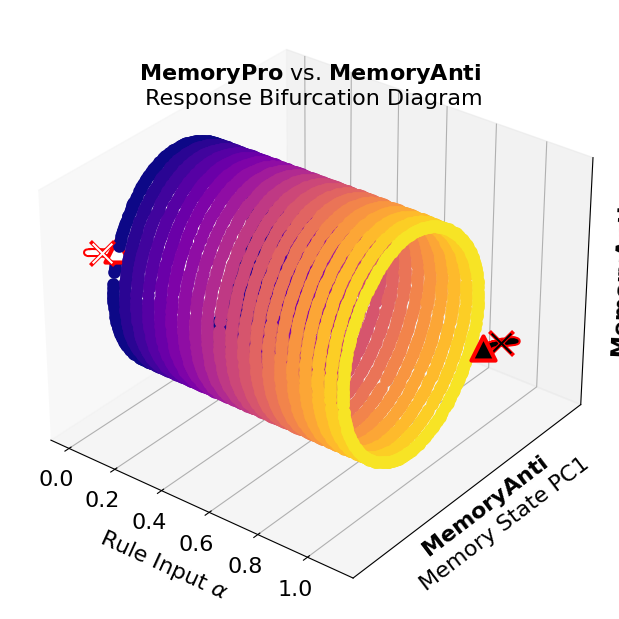

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
w
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/dat

/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2970: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatib

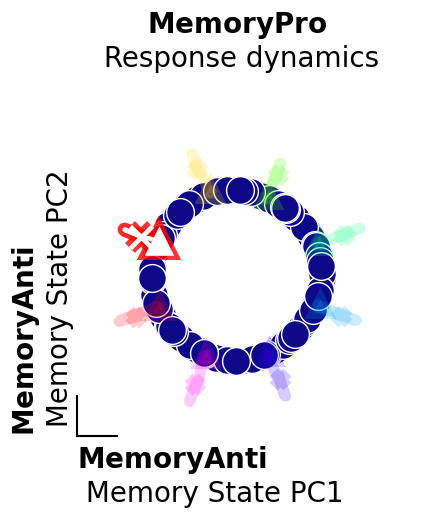

k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
8
4
1
go1


/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2970: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


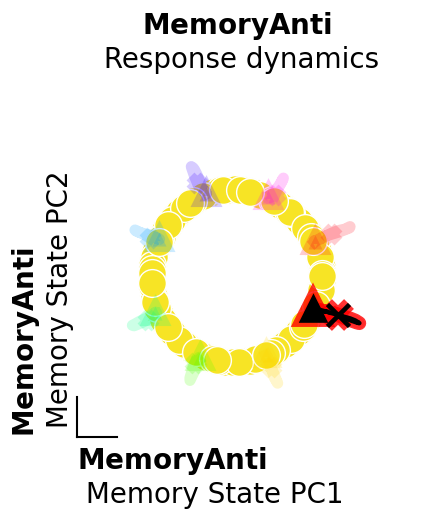

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/

/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3293: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatib

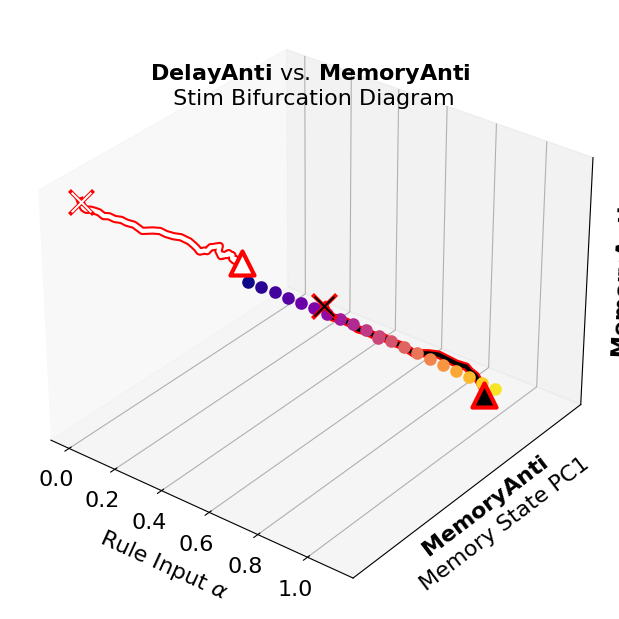

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/

/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2970: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatib

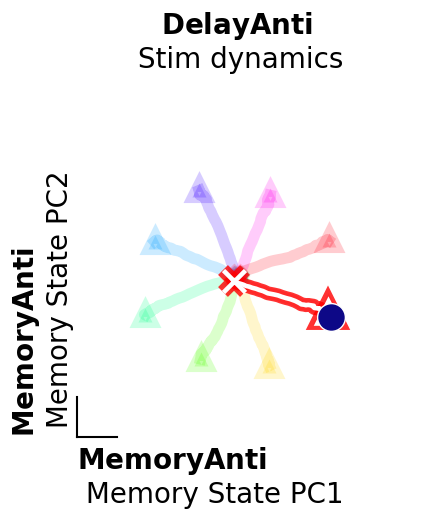

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/mem_anti_motifs/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_delaygo_fdanti_post_train_delayanti_0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/dat

/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2970: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


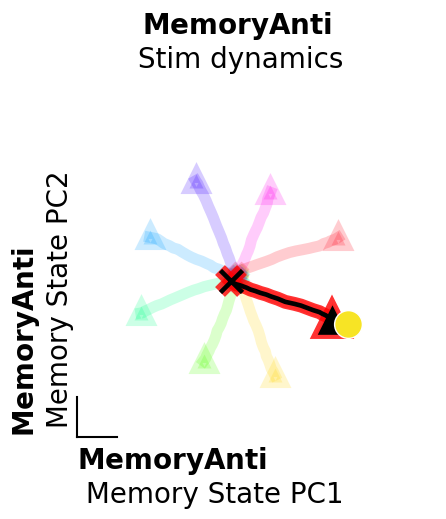

In [8]:
from tools_lnd import gen_trial_set,bifurc,plot_bifurc_ends, take_names
ruleset = 'mem_anti_motifs'
ax_labels = 'pca_h'
fig_size = 6
cmap_discrete = ['w','k']

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
seed = '0'
file = '_'.join([rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed])
m = os.path.join(p_data,fig_name,ruleset,file)
# rule_set = ['delaygo','delayanti']
# epoch_set = ['delay1','delay1']
# t_set = [0,0]
# ri_axs = 1
# epoch = epoch_set[ri_axs]
# rule = rule_set[ri_axs]
# trial = gen_trials_from_model_dir(m,rule,noise_on = False)
# filename,_ = get_filename(trial,epoch,0)
# f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
# D_use = make_FP_axs(f, m, rule, epoch, axs = 'pca_h', clust = 'False')
# w_in, b_in, w_out, b_out = get_model_params(m)
# D_use[:,2] = w_out[:,1]

# interp = False

rule_set = [2,5]
# rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
epoch_set = ['delay1','delay1']
t_set = [0,0]
rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = ax_labels, clust = 'False')
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,0] = -D_use[:,0]
D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}
ax_labels[1] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1'
ax_labels[2] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[0] = r"Rule Input $\alpha$"

interp = False
script_name = 'interp_tasks_small_init_mov_transfer'
tol_q = 1e-6
q_thresh = 1e-7

# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
#                    lims = [], view_ang = [31,-52])

# plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
#                  q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, ruleset = ruleset)

epoch_set = ['go1','go1']
t_set = [0,0]

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
                   lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
                 q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

rule_set = [3,5]
trial_set = gen_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs,['fix1','fix1'],t_set)
D_use[:,2] = D_fp_qr[:,0]

epoch_set = ['stim1','stim1']
t_set = [0,0]

q_thresh = 1e-9

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
                   lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
                 q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
delay1
go1
go1
go1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexi

/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3293: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatib

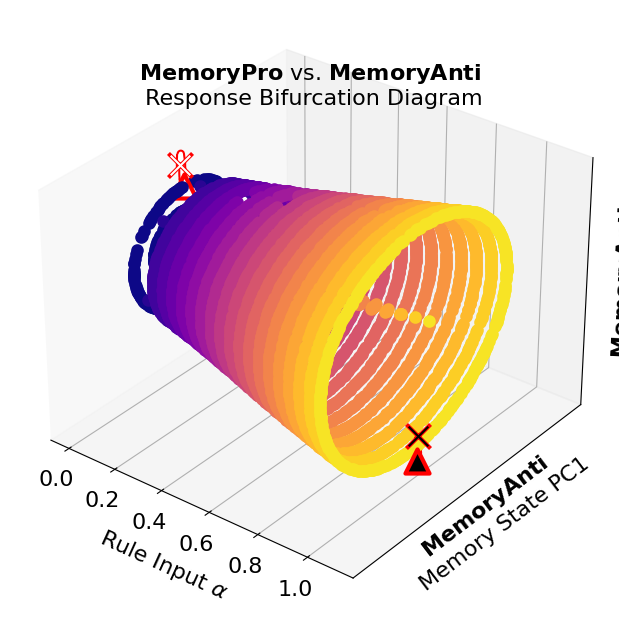

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
w
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig

/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2970: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatib

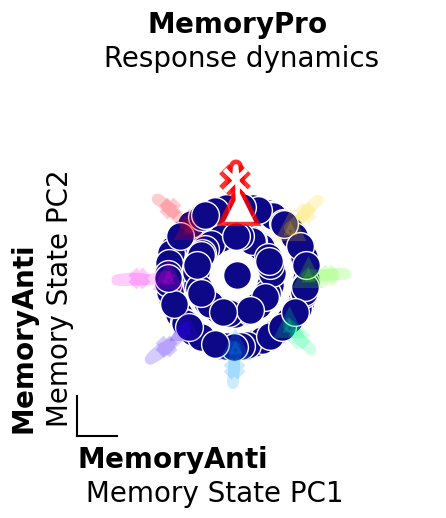

k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
8
4
1
go1


/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2970: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


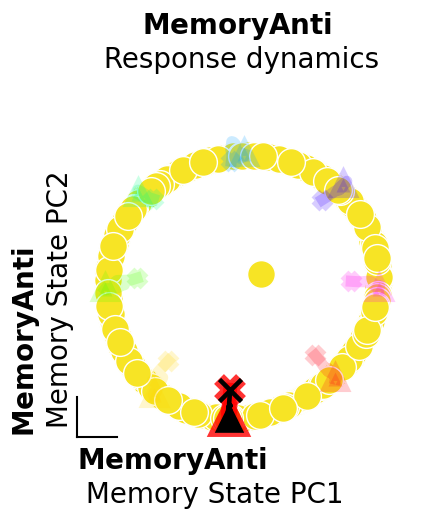

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/

/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3292: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:3293: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatib

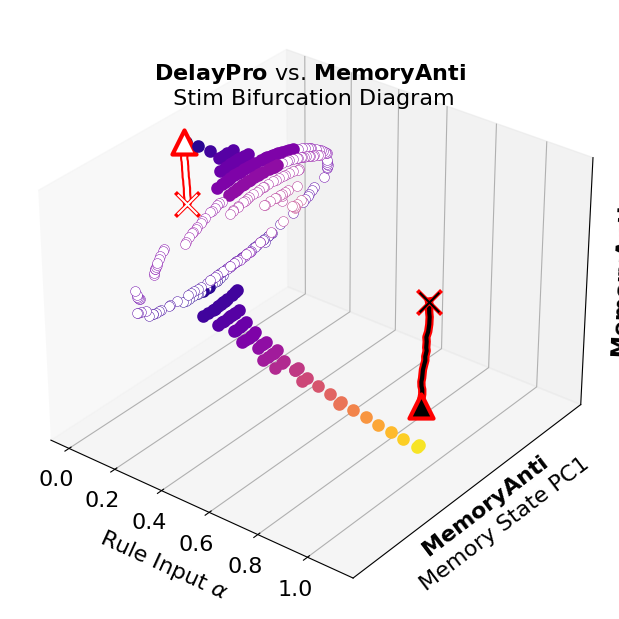

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
w
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig

/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2970: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatib

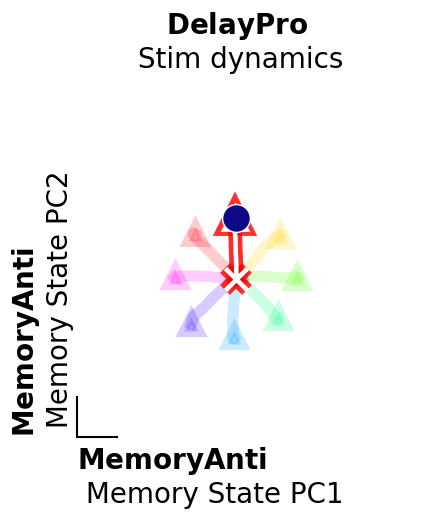

k
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 256) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/fig6/pro_small/LeakyRNN_softplus_diag_2_tasks_256_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_delaygo_post_train_delayanti_1/model.ckpt
8
4
1
stim1


/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2969: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.pdf'),bbox_inches='tight')
/Users/lauradriscoll/Documents/code/flexible_multitask/transfer_learn/tools_lnd.py:2970: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(os.path.join(figpath,fig_fldr,tit_name+'.png'))
/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


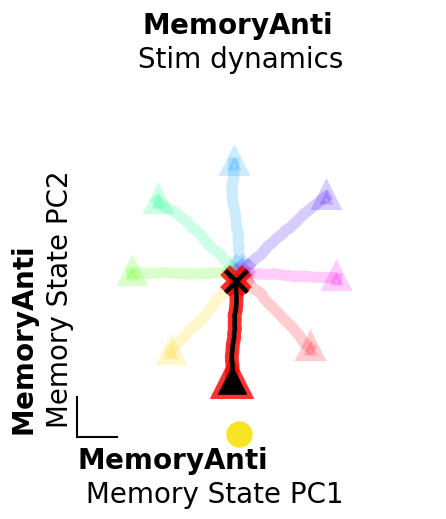

In [10]:
from tools_lnd import bifurc, plot_bifurc_ends, bifurc
fig_size = 6
ruleset = 'pro_small'
ax_labels = 'pca_h'
cmap_discrete = ['w','k']

task_set = rules_dict[ruleset]
if ruleset=='all':
    task_set = ['fdgo','reactgo','delaygo','fdanti','reactanti','delayanti','delaydm1','delaydm2',
                'contextdelaydm1','contextdelaydm2','multidelaydm','dmsgo','dmsnogo','dmcgo','dmcnogo']
    task_set.pop(5)
rule_trains_str = '_'.join(task_set)
n_tasks = str(len(task_set))

net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
seed = '1'
file = '_'.join([rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,'post_train_'+post_train,seed])
m = os.path.join(p_data,fig_name,ruleset,file)

rule_set = [2,5]
# rule_set = [rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]
epoch_set = ['delay1','delay1']
t_set = [0,0]
rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,0)
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use = make_FP_axs(f, m, rule, epoch, axs = ax_labels, clust = 'False')
w_in, b_in, w_out, b_out = get_model_params(m)

D_use[:,2] = w_out[:,2]

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rule)
ax_labels = {}
ax_labels[1] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC1'
ax_labels[2] = r"$\bf{"+rule_name_ax+"}$"+' \n '+epoch_name_ax+' State PC2'
ax_labels[0] = r"Rule Input $\alpha$"


interp = False
script_name = 'interp_tasks_small_init_mov_transfer'
tol_q = 1e-6
q_thresh = 1e-5


# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
#                    lims = [], view_ang = [31,-52])

# plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
#                  q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, 
#                  ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

# bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#            title_y = .9, n_trials = 8, stability_thresh = 2, threeD = True,cmap_discrete =  cmap_discrete,
#            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = .1, 
#            bifurc = False, plot_zero_plane = True)

rule_set = [2,5]
epoch_set = ['go1','go1']
t_set = [0,0]

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 2, 
                   lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = True, 
                 q_thresh = q_thresh,stability_thresh = 2, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

# bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#            title_y = .9, n_trials = 8, stability_thresh = 2, threeD = True,cmap_discrete = cmap_discrete,
#            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = 0, 
#            bifurc = False, plot_zero_plane = True)

rule_set = [0,5]
trial_set = gen_trial_set(m,rule_set)
D_fp_qr = gen_D_fp_qr(m,trial_set,rule_axs,['fix1','fix1'],t_set)
D_use[:,2] = D_fp_qr[:,0]

epoch_set = ['stim1','stim1']
t_set = [0,0]
script_name = 'interp_tasks_small_init_stim_transfer'

q_thresh = 1e-7

# bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
#      q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
#      n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
#      figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
#                    lims = [], view_ang = [31,-52])

# plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
#                  q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, ruleset = ruleset)

# script_name = 'interp_tasks_small_init_mov_transfer'

bifurc(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = cmap_discrete,
     q_thresh = q_thresh,rule_axs = rule_axs, plot_unstable = True,title_y = .9,
     n_skip_interps=1,color_stim = True,fig_size = fig_size,fontsize = 16, threeD = True,
     figpath = figpath,ruleset = ruleset,ax_labels = ax_labels, stability_thresh = 1, 
                   lims = [], view_ang = [31,-52])

plot_bifurc_ends(m,D_use,rule_set,epoch_set,script_name, lims = [],fac_mult_lims = 2,fp_first = False, 
                 q_thresh = q_thresh,stability_thresh = 1, color_stim = True, figpath = figpath, 
                 ruleset = ruleset,ax_labels = [ax_labels[1],ax_labels[2]])

# bifurc(m,D_use,rule_set,epoch_set,rule_axs = rule_axs,ax_labels = ax_labels,script_name = script_name,
#            color_stim = True, fig_size = 6, fontsize = 20, figpath = figpath, ruleset = ruleset,
#            title_y = .9, n_trials = 8, stability_thresh = 1, threeD = True,cmap_discrete = cmap_discrete,
#            lw = 10,ms = 10,linestyle = '-',al_state = 1,al_fp = 0, 
#            bifurc = False, plot_zero_plane = False)
